# NekRS-ML GNN Scaling

In [1]:
# Set up notebook
import os
import pathlib
import glob
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

from datetime import datetime

font = {
        'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

import matplotlib.font_manager
# matplotlib.font_manager.fontManager.ttflist

In [2]:
class NekRSML_GNN:
    def __init__(self,path,gpu_list):
        self.base_path = path
        self.gpu_list = gpu_list
        self.n_gpu = len(gpu_list)
        self.train_fom = {
            'train_tot': np.zeros((self.n_gpu,)),
            'train_epoch': np.zeros((self.n_gpu,4)),
            'throughput_epoch': np.zeros((self.n_gpu,4)),
            'train_batch': np.zeros((self.n_gpu,4)),
            'throughput_par': np.zeros((self.n_gpu,)),
            'forward_pass': np.zeros((self.n_gpu,4)),
            'loss': np.zeros((self.n_gpu,4)),
            'backward_pass': np.zeros((self.n_gpu,4)),
            'optimizer_step': np.zeros((self.n_gpu,4)),
            'data_offload': np.zeros((self.n_gpu,4)),
            'buffer_init': np.zeros((self.n_gpu,4)),
            'collectives': np.zeros((self.n_gpu,4))
        }
        
    def get_value(self,string):
        if 'INFO' in string:
            string = string.split(" - ")[1]
        return float(string.split(":")[1].strip())
    
    def get_values(self,string):
        if 'INFO' in string:
            string = string.split(" - ")[1]
        vals = string.split(":")[1].split(",")
        arr = np.zeros((4,))
        for i in range(4):
            arr[i] = float(vals[i].split('=')[-1].strip())
        return arr
    
    def parse_files(self):
        counts = np.zeros((self.n_gpu,))
        for i in range(self.n_gpu):
            path = self.base_path+f"/{self.gpu_list[i]}/gnn_scale*"
            # Loop over runs found
            run_files = glob.glob(path)
            for run_file in run_files:
                print('Reading file: ', run_file)
                with open(run_file,'r') as fh:
                    for l in fh:
                        if "Total training time" in l and "::" not in l:
                            self.train_fom['train_tot'][i] += self.get_value(l)
                            counts[i] += 1
                        if "Training epoch" in l:
                            self.train_fom['train_epoch'][i] += self.get_values(l)
                        if "Training throughput" in l:
                            self.train_fom['throughput_epoch'][i] += self.get_values(l)
                        if "Average parallel training throughout" in l:
                            self.train_fom['throughput_par'][i] += self.get_value(l)
                        if "Training batch" in l:
                            self.train_fom['train_batch'][i] += self.get_values(l)
                        if "forwardPass" in l:
                            self.train_fom['forward_pass'][i] += self.get_values(l)
                        if "loss [" in l:
                            self.train_fom['loss'][i] += self.get_values(l)
                        if "backwardPass" in l:
                            self.train_fom['backward_pass'][i] += self.get_values(l)
                        if "optimizerStep" in l:
                            self.train_fom['optimizer_step'][i] += self.get_values(l)
                        if "dataTransfer" in l:
                            self.train_fom['data_offload'][i] += self.get_values(l)
                        if "bufferInit" in l:
                            self.train_fom['buffer_init'][i] += self.get_values(l)
                        if "collectives" in l:
                            self.train_fom['collectives'][i] += self.get_values(l)

        # Divide by the counts for each gpu number to get the average over runs
        for key in self.train_fom.keys():
            val = self.train_fom[key]
            if len(val.shape)==1:
                self.train_fom[key] = np.divide(val, counts, where=counts>0)
            else:
                for j in range(val.shape[1]):
                    self.train_fom[key][:,j] = np.divide(val[:,j], counts, where=counts>0)
        
#    def compute_scaling_efficiency(self):
#        self.sim_runtime_eta = self.sim_runtime/self.sim_runtime[0]
#        self.sim_steps_eta = self.sim_steps/self.sim_steps[0]
#        self.sim_sr_init_eta = self.sim_sr_init/self.sim_sr_init[0]
#        self.sim_sr_meta_eta = self.sim_sr_meta/self.sim_sr_meta[0]
#        self.sim_sr_train_eta = self.sim_sr_train/self.sim_sr_train[0]
#        self.ml_runtime_eta = self.ml_runtime/self.ml_runtime[0]
#        self.ml_sr_init_eta = self.ml_sr_init/self.ml_sr_init[0]
#        self.ml_sr_meta_eta = self.ml_sr_meta/self.ml_sr_meta[0]
#        self.ml_sr_train_eta = self.ml_sr_train/self.ml_sr_train[0]

In [ ]:
# Test class
top_dir = "/Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/none"
gpu_list = [1,2,4]
test = NekRSML_GNN(top_dir,gpu_list)
test.parse_files()
print(test.train_fom)

## Load All Data

In [3]:
top_dir = "/Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/"

In [29]:
#### Polaris
# NekRS-ML Model, no halo exchange
case_dir = "polaris/none"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8, 16, 32, 64]
polaris_no = NekRSML_GNN(dir_path,gpu_list)
polaris_no.parse_files()

# NekRS-ML Model, all_to_all halo exchange
case_dir = "polaris/all2all"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8, 16, 32, 64]
polaris_a2a = NekRSML_GNN(dir_path,gpu_list)
polaris_a2a.parse_files()

# NekRS-ML Model, all_to_all_opt exchange
case_dir = "polaris/all2all_opt"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8, 16, 32, 64]
polaris_a2ao = NekRSML_GNN(dir_path,gpu_list)
polaris_a2ao.parse_files()

# NekRS-ML Model, all_to_all_opt exchange with small model
case_dir = "polaris/all2all_opt_small_model"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8]
polaris_a2ao_sm = NekRSML_GNN(dir_path,gpu_list)
polaris_a2ao_sm.parse_files()

# NekRS-ML Model, send_recv exchange with small model
case_dir = "polaris/send_recv_small_model"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8]
polaris_sr_sm = NekRSML_GNN(dir_path,gpu_list)
polaris_sr_sm.parse_files()

#### Aurora
# NekRS-ML Model, no halo exchange
case_dir = "aurora/none"
dir_path = top_dir + case_dir
gpu_list = [0.5, 1, 3, 6, 12, 24, 48, 96, 192, 384, 768]
aurora_no = NekRSML_GNN(dir_path,gpu_list)
aurora_no.parse_files()

# NekRS-ML Model, all_to_all halo exchange
case_dir = "aurora/all2all"
dir_path = top_dir + case_dir
gpu_list = [0.5, 1, 3, 6, 12, 24, 48, 96, 192, 384, 768]
aurora_a2a = NekRSML_GNN(dir_path,gpu_list)
aurora_a2a.parse_files()

# NekRS-ML Model, all_to_all_opt exchange
case_dir = "aurora/all2all_opt"
dir_path = top_dir + case_dir
gpu_list = [0.5, 1, 3, 6, 12, 24, 48, 96, 192, 384, 768]
aurora_a2ao = NekRSML_GNN(dir_path,gpu_list)
aurora_a2ao.parse_files()


Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/none/1/gnn_scale.o2028293
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/none/1/gnn_scale.o2016243
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/none/2/gnn_scale.o2029277
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/none/2/gnn_scale.o2016243
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/none/4/gnn_scale.o2029277
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/none/4/gnn_scale.o2016243
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/none/8/gnn_scale.o2029283
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/none/8/gnn_scale.o2018520
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/none/16/gnn_scale.o2021416
Reading file:  /Us

## Scale-Up of NekRS-ML GNN (Single Node)

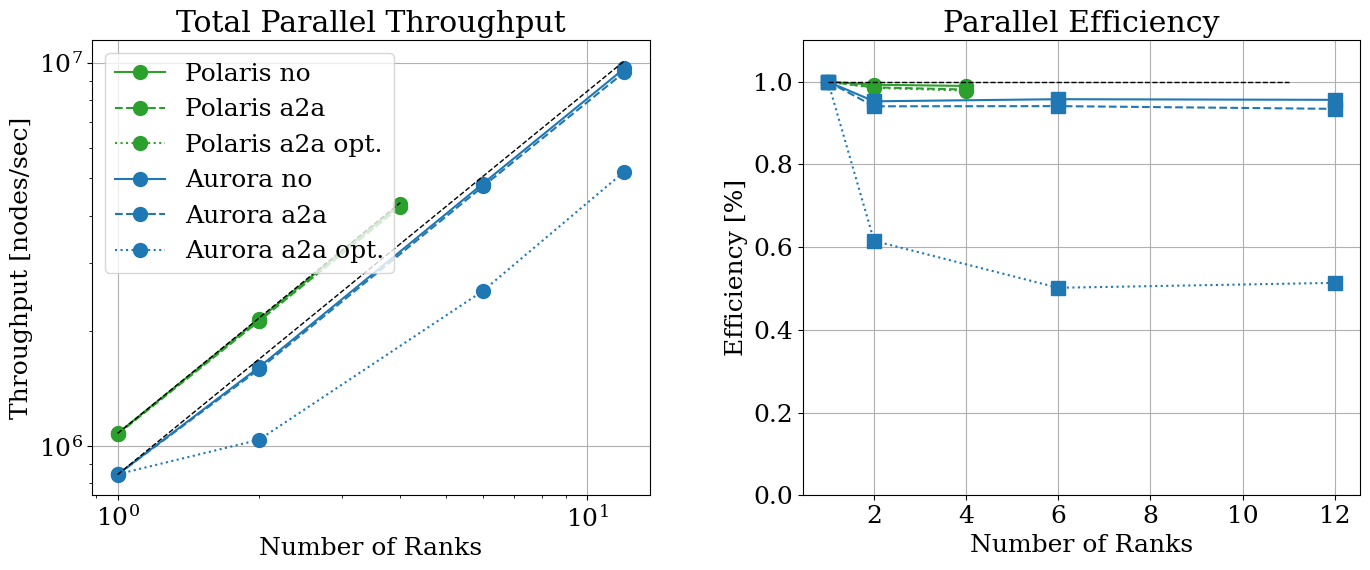

In [10]:
# Average parallel training throughput

polaris_gpu_list = [1, 2, 4]
aurora_gpu_list = [0.5, 1, 3, 6]
aurora_rank_list = [1, 2, 6, 12]

polaris_no_serial = polaris_no.train_fom['throughput_par'][0]
polaris_no_ideal = [polaris_gpu_list[i]*polaris_no_serial for i in range(len(polaris_gpu_list))]
polaris_a2a_serial = polaris_a2a.train_fom['throughput_par'][0]
polaris_a2a_ideal = [polaris_gpu_list[i]*polaris_a2a_serial for i in range(len(polaris_gpu_list))]
polaris_a2ao_serial = polaris_a2ao.train_fom['throughput_par'][0]
polaris_a2ao_ideal = [polaris_gpu_list[i]*polaris_a2ao_serial for i in range(len(polaris_gpu_list))]

aurora_no_serial = aurora_no.train_fom['throughput_par'][0]
aurora_no_ideal = [aurora_gpu_list[i]/aurora_gpu_list[0]*aurora_no_serial for i in range(len(aurora_gpu_list))]
aurora_a2a_serial = aurora_a2a.train_fom['throughput_par'][0]
aurora_a2a_ideal = [aurora_gpu_list[i]/aurora_gpu_list[0]*aurora_a2a_serial for i in range(len(aurora_gpu_list))]
aurora_a2ao_serial = aurora_a2ao.train_fom['throughput_par'][0]
aurora_a2ao_ideal = [aurora_gpu_list[i]/aurora_gpu_list[0]*aurora_a2ao_serial for i in range(len(aurora_gpu_list))]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axs[0].plot(polaris_gpu_list, polaris_no.train_fom['throughput_par'][:3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[0].plot(polaris_gpu_list, polaris_a2a.train_fom['throughput_par'][:3],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
axs[0].plot(polaris_gpu_list, polaris_a2ao.train_fom['throughput_par'][:3],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')
axs[0].plot(polaris_gpu_list, polaris_no_ideal,c="k",ls="--",linewidth=1)

axs[0].plot(aurora_rank_list, aurora_no.train_fom['throughput_par'][:4],label = "Aurora no",marker="o",ls="-",markersize=10,color='tab:blue')
axs[0].plot(aurora_rank_list, aurora_a2a.train_fom['throughput_par'][:4],label = "Aurora a2a",marker="o",ls="--",markersize=10,color='tab:blue')
axs[0].plot(aurora_rank_list, aurora_a2ao.train_fom['throughput_par'][:4],label = "Aurora a2a opt.",marker="o",ls=":",markersize=10,color='tab:blue')
axs[0].plot(aurora_rank_list, aurora_no_ideal,c="k",ls="--",linewidth=1)


axs[1].plot(polaris_gpu_list, polaris_no.train_fom['throughput_par'][:3]/polaris_no_ideal,label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[1].plot(polaris_gpu_list, polaris_a2a.train_fom['throughput_par'][:3]/polaris_a2a_ideal,label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
axs[1].plot(polaris_gpu_list, polaris_a2ao.train_fom['throughput_par'][:3]/polaris_a2ao_ideal,label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs[1].plot(aurora_rank_list, aurora_no.train_fom['throughput_par'][:4]/aurora_no_ideal,label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs[1].plot(aurora_rank_list, aurora_a2a.train_fom['throughput_par'][:4]/aurora_a2a_ideal,label = "Aurora no",marker="s",ls="--",markersize=10,color='tab:blue')
axs[1].plot(aurora_rank_list, aurora_a2ao.train_fom['throughput_par'][:4]/aurora_a2ao_ideal,label = "Aurora no",marker="s",ls=":",markersize=10,color='tab:blue')
axs[1].plot([i for i in range(1,12)], [1 for i in range(1,12)],c="k",ls="--",linewidth=1)


for i in range(2):
    #axs[i].set_xscale("log")
    axs[i].grid()
    axs[i].set_xlabel('Number of Ranks')

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[1].set_ylim(0,1.1)
#fig.legend(bbox_to_anchor=(1.25,0.7))
axs[0].legend(loc='upper left')
axs[0].set_ylabel('Throughput [nodes/sec]')
axs[0].set_title('Total Parallel Throughput')
axs[1].set_ylabel('Efficiency [%]')
axs[1].set_title('Parallel Efficiency')
fig.tight_layout(pad=3.0)

[0.44900818 0.2843514  0.2849125 ]
[0.45117956 0.1099927  0.10968485]
[0.44935017 0.109416   0.10935025]


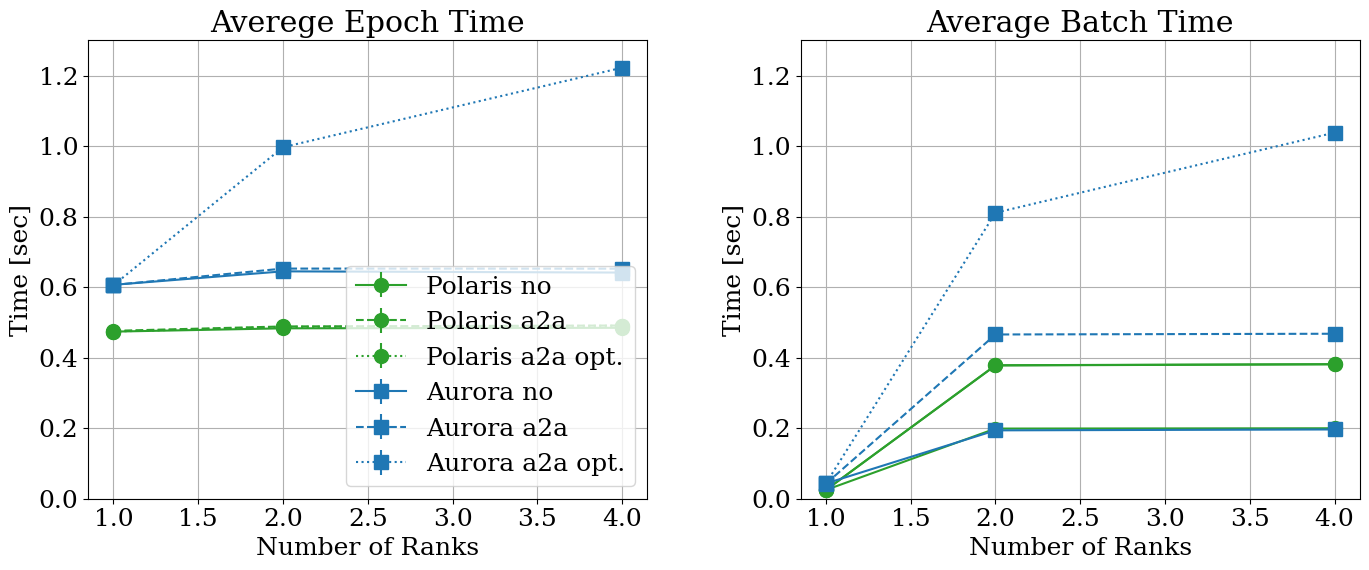

In [11]:
# Training epoch and batch

polaris_gpu_list = [1, 2, 4]
aurora_gpu_list = [0.5, 1, 3, 6]
aurora_rank_list = [1, 2, 6, 12]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axs[0].errorbar(polaris_gpu_list, polaris_no.train_fom['train_epoch'][:3,2],polaris_no.train_fom['train_epoch'][:3,3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[0].errorbar(polaris_gpu_list, polaris_a2a.train_fom['train_epoch'][:3,2],polaris_a2a.train_fom['train_epoch'][:3,3],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
axs[0].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['train_epoch'][:3,2],polaris_a2ao.train_fom['train_epoch'][:3,3],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs[0].errorbar(polaris_gpu_list, aurora_no.train_fom['train_epoch'][:3,2],aurora_no.train_fom['train_epoch'][:3,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs[0].errorbar(polaris_gpu_list, aurora_a2a.train_fom['train_epoch'][:3,2],aurora_a2a.train_fom['train_epoch'][:3,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs[0].errorbar(polaris_gpu_list, aurora_a2ao.train_fom['train_epoch'][:3,2],aurora_a2ao.train_fom['train_epoch'][:3,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')

axs[1].errorbar(polaris_gpu_list, polaris_no.train_fom['train_batch'][:3,2],polaris_no.train_fom['train_batch'][:3,3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[1].errorbar(polaris_gpu_list, polaris_a2a.train_fom['train_batch'][:3,2],polaris_a2a.train_fom['train_batch'][:3,3],label = "Polaris a2a",marker="o",ls="-",markersize=10,color='tab:green')
axs[1].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['train_batch'][:3,2],polaris_a2ao.train_fom['train_batch'][:3,3],label = "Polaris a2a opt.",marker="o",ls="-",markersize=10,color='tab:green')

axs[1].errorbar(polaris_gpu_list, aurora_no.train_fom['train_batch'][:3,2],aurora_no.train_fom['train_batch'][:3,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs[1].errorbar(polaris_gpu_list, aurora_a2a.train_fom['train_batch'][:3,2],aurora_a2a.train_fom['train_batch'][:3,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs[1].errorbar(polaris_gpu_list, aurora_a2ao.train_fom['train_batch'][:3,2],aurora_a2ao.train_fom['train_batch'][:3,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')


for i in range(2):
    #axs[i].set_xscale("log")
    axs[i].grid()
    axs[i].set_xlabel('Number of Ranks')
    axs[i].set_ylim(0, 1.3)

#axs[0].set_xscale("log")
#axs[0].set_yscale("log")
#fig.legend(bbox_to_anchor=(1.25,0.7))
axs[0].legend(loc='lower right')
axs[0].set_ylabel('Time [sec]')
axs[0].set_title('Averege Epoch Time')
axs[1].set_ylabel('Time [sec]')
axs[1].set_title('Average Batch Time')
fig.tight_layout(pad=3.0)

print(polaris_no.train_fom['train_epoch'][:3,2]-polaris_no.train_fom['train_batch'][:3,2])
print(polaris_a2a.train_fom['train_epoch'][:3,2]-polaris_a2a.train_fom['train_batch'][:3,2])
print(polaris_a2ao.train_fom['train_epoch'][:3,2]-polaris_a2ao.train_fom['train_batch'][:3,2])

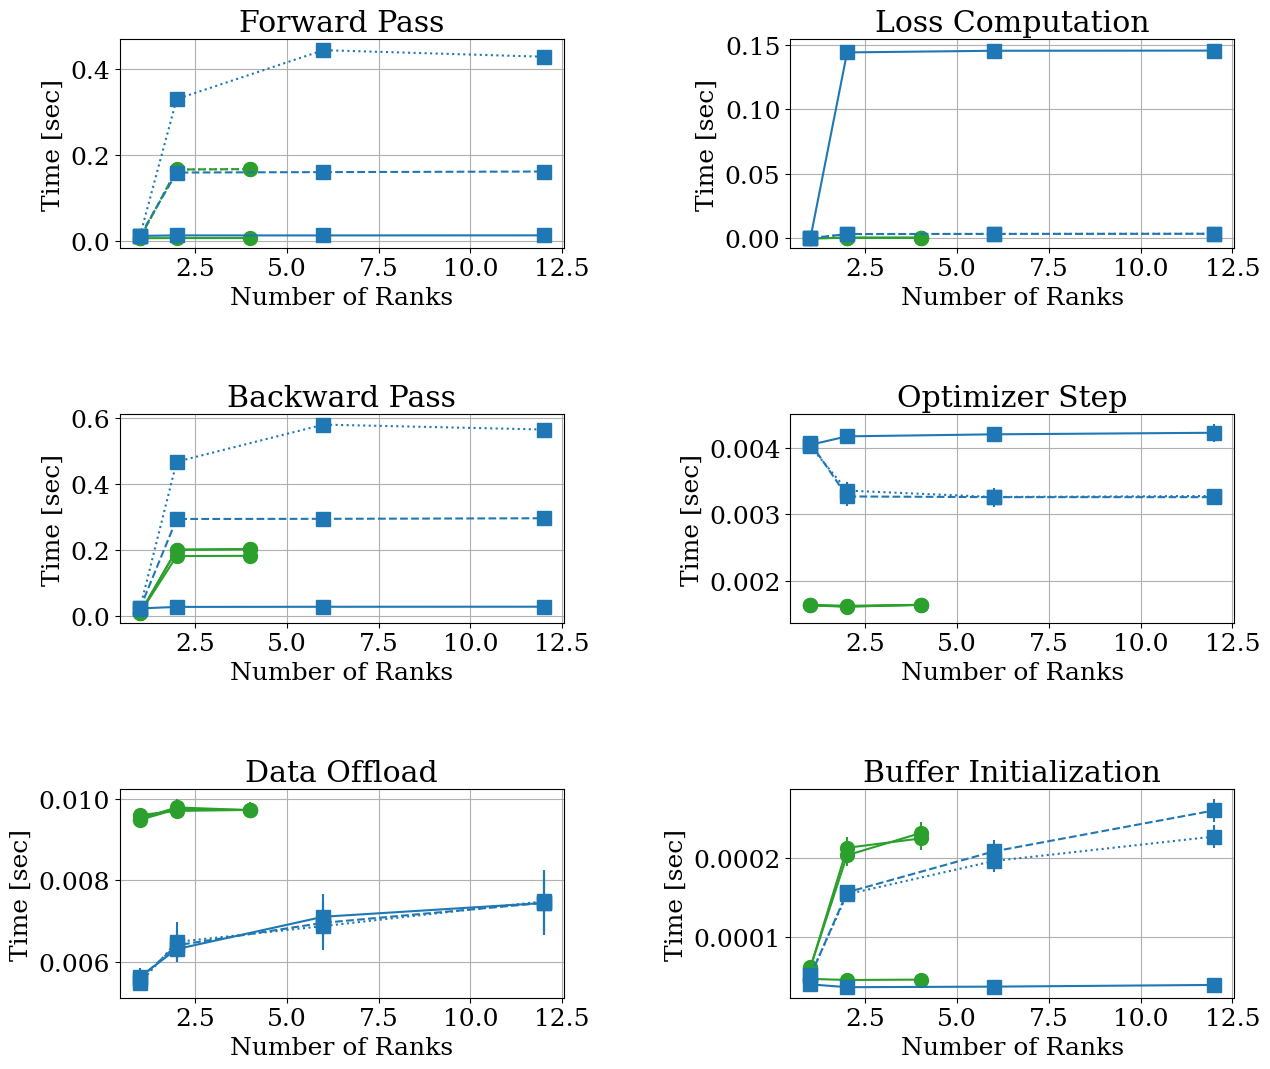

In [12]:
# Iteration timings

polaris_gpu_list = [1, 2, 4]
aurora_gpu_list = [0.5, 1, 3, 6]
aurora_rank_list = [1, 2, 6, 12]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
axs[0,0].errorbar(polaris_gpu_list, polaris_no.train_fom['forward_pass'][:3,2],polaris_no.train_fom['forward_pass'][:3,3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[0,0].errorbar(polaris_gpu_list, polaris_a2a.train_fom['forward_pass'][:3,2],polaris_a2a.train_fom['forward_pass'][:3,3],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
axs[0,0].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['forward_pass'][:3,2],polaris_a2ao.train_fom['forward_pass'][:3,3],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs[0,0].errorbar(aurora_rank_list, aurora_no.train_fom['forward_pass'][:4,2],aurora_no.train_fom['forward_pass'][:4,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs[0,0].errorbar(aurora_rank_list, aurora_a2a.train_fom['forward_pass'][:4,2],aurora_a2a.train_fom['forward_pass'][:4,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs[0,0].errorbar(aurora_rank_list, aurora_a2ao.train_fom['forward_pass'][:4,2],aurora_a2ao.train_fom['forward_pass'][:4,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')


axs[0,1].errorbar(polaris_gpu_list, polaris_no.train_fom['loss'][:3,2],polaris_no.train_fom['loss'][:3,3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[0,1].errorbar(polaris_gpu_list, polaris_a2a.train_fom['loss'][:3,2],polaris_a2a.train_fom['loss'][:3,3],label = "Polaris a2a",marker="o",ls="-",markersize=10,color='tab:green')
axs[0,1].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['loss'][:3,2],polaris_a2ao.train_fom['loss'][:3,3],label = "Polaris a2a opt.",marker="o",ls="-",markersize=10,color='tab:green')
axs[0,1].errorbar(aurora_rank_list, aurora_no.train_fom['loss'][:4,2],aurora_no.train_fom['loss'][:4,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs[0,1].errorbar(aurora_rank_list, aurora_a2a.train_fom['loss'][:4,2],aurora_a2a.train_fom['loss'][:4,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs[0,1].errorbar(aurora_rank_list, aurora_a2ao.train_fom['loss'][:4,2],aurora_a2ao.train_fom['loss'][:4,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')

axs[1,0].errorbar(polaris_gpu_list, polaris_no.train_fom['backward_pass'][:3,2],polaris_no.train_fom['backward_pass'][:3,3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[1,0].errorbar(polaris_gpu_list, polaris_a2a.train_fom['backward_pass'][:3,2],polaris_a2a.train_fom['backward_pass'][:3,3],label = "Polaris a2a",marker="o",ls="-",markersize=10,color='tab:green')
axs[1,0].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['backward_pass'][:3,2],polaris_a2ao.train_fom['backward_pass'][:3,3],label = "Polaris a2a opt.",marker="o",ls="-",markersize=10,color='tab:green')
axs[1,0].errorbar(aurora_rank_list, aurora_no.train_fom['backward_pass'][:4,2],aurora_no.train_fom['backward_pass'][:4,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs[1,0].errorbar(aurora_rank_list, aurora_a2a.train_fom['backward_pass'][:4,2],aurora_a2a.train_fom['backward_pass'][:4,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs[1,0].errorbar(aurora_rank_list, aurora_a2ao.train_fom['backward_pass'][:4,2],aurora_a2ao.train_fom['backward_pass'][:4,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')

axs[1,1].errorbar(polaris_gpu_list, polaris_no.train_fom['optimizer_step'][:3,2],polaris_no.train_fom['optimizer_step'][:3,3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[1,1].errorbar(polaris_gpu_list, polaris_a2a.train_fom['optimizer_step'][:3,2],polaris_a2a.train_fom['optimizer_step'][:3,3],label = "Polaris a2a",marker="o",ls="-",markersize=10,color='tab:green')
axs[1,1].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['optimizer_step'][:3,2],polaris_a2ao.train_fom['optimizer_step'][:3,3],label = "Polaris a2a opt.",marker="o",ls="-",markersize=10,color='tab:green')
axs[1,1].errorbar(aurora_rank_list, aurora_no.train_fom['optimizer_step'][:4,2],aurora_no.train_fom['optimizer_step'][:4,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs[1,1].errorbar(aurora_rank_list, aurora_a2a.train_fom['optimizer_step'][:4,2],aurora_a2a.train_fom['optimizer_step'][:4,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs[1,1].errorbar(aurora_rank_list, aurora_a2ao.train_fom['optimizer_step'][:4,2],aurora_a2ao.train_fom['optimizer_step'][:4,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')

axs[2,0].errorbar(polaris_gpu_list, polaris_no.train_fom['data_offload'][:3,2],polaris_no.train_fom['data_offload'][:3,3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[2,0].errorbar(polaris_gpu_list, polaris_a2a.train_fom['data_offload'][:3,2],polaris_a2a.train_fom['data_offload'][:3,3],label = "Polaris a2a",marker="o",ls="-",markersize=10,color='tab:green')
axs[2,0].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['data_offload'][:3,2],polaris_a2ao.train_fom['data_offload'][:3,3],label = "Polaris a2a opt.",marker="o",ls="-",markersize=10,color='tab:green')
axs[2,0].errorbar(aurora_rank_list, aurora_no.train_fom['data_offload'][:4,2],aurora_no.train_fom['data_offload'][:4,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs[2,0].errorbar(aurora_rank_list, aurora_a2a.train_fom['data_offload'][:4,2],aurora_a2a.train_fom['data_offload'][:4,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs[2,0].errorbar(aurora_rank_list, aurora_a2ao.train_fom['data_offload'][:4,2],aurora_a2ao.train_fom['data_offload'][:4,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')

axs[2,1].errorbar(polaris_gpu_list, polaris_no.train_fom['buffer_init'][:3,2],polaris_no.train_fom['buffer_init'][:3,3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[2,1].errorbar(polaris_gpu_list, polaris_a2a.train_fom['buffer_init'][:3,2],polaris_a2a.train_fom['buffer_init'][:3,3],label = "Polaris a2a",marker="o",ls="-",markersize=10,color='tab:green')
axs[2,1].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['buffer_init'][:3,2],polaris_a2ao.train_fom['buffer_init'][:3,3],label = "Polaris a2a opt.",marker="o",ls="-",markersize=10,color='tab:green')
axs[2,1].errorbar(aurora_rank_list, aurora_no.train_fom['buffer_init'][:4,2],aurora_no.train_fom['buffer_init'][:4,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs[2,1].errorbar(aurora_rank_list, aurora_a2a.train_fom['buffer_init'][:4,2],aurora_a2a.train_fom['buffer_init'][:4,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs[2,1].errorbar(aurora_rank_list, aurora_a2ao.train_fom['buffer_init'][:4,2],aurora_a2ao.train_fom['buffer_init'][:4,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')


for i in range(3):
    for j in range(2):
    #axs[i].set_xscale("log")
        axs[i,j].grid()
        axs[i,j].set_xlabel('Number of Ranks')
        axs[i,j].set_ylabel('Time [sec]')

axs[0,0].set_title('Forward Pass')
axs[0,1].set_title('Loss Computation')
axs[1,0].set_title('Backward Pass')
axs[1,1].set_title('Optimizer Step')
axs[2,0].set_title('Data Offload')
axs[2,1].set_title('Buffer Initialization')
fig.tight_layout(pad=3.0)

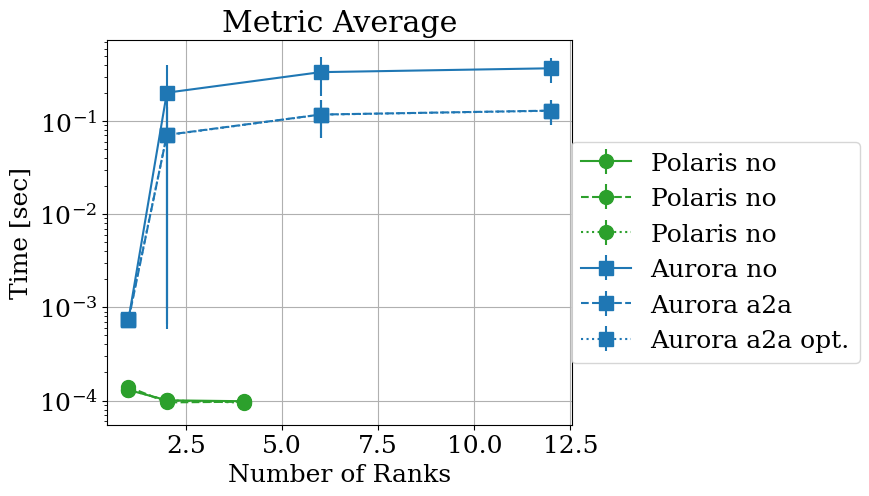

In [23]:
# Metric average for loss

polaris_gpu_list = [1, 2, 4]
aurora_gpu_list = [0.5, 1, 3, 6]
aurora_rank_list = [1, 2, 6, 12]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
axs.errorbar(polaris_gpu_list, polaris_no.train_fom['collectives'][:3,2],polaris_no.train_fom['collectives'][:3,3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs.errorbar(polaris_gpu_list, polaris_a2a.train_fom['collectives'][:3,2],polaris_a2a.train_fom['collectives'][:3,3],label = "Polaris no",marker="o",ls="--",markersize=10,color='tab:green')
axs.errorbar(polaris_gpu_list, polaris_a2ao.train_fom['collectives'][:3,2],polaris_a2ao.train_fom['collectives'][:3,3],label = "Polaris no",marker="o",ls=":",markersize=10,color='tab:green')

axs.errorbar(aurora_rank_list, aurora_no.train_fom['collectives'][:4,2],aurora_no.train_fom['collectives'][:4,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs.errorbar(aurora_rank_list, aurora_a2a.train_fom['collectives'][:4,2],aurora_a2a.train_fom['collectives'][:4,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs.errorbar(aurora_rank_list, aurora_a2ao.train_fom['collectives'][:4,2],aurora_a2ao.train_fom['collectives'][:4,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')

axs.set_yscale("log")
axs.grid()
axs.set_xlabel('Number of Ranks')
axs.set_ylabel('Time [sec]')

axs.set_title('Metric Average')
fig.legend(bbox_to_anchor=(1.4,0.7))
#axs[0,1].set_title('Loss Computation')
#axs[1,0].set_title('Backward Pass')
#axs[1,1].set_title('Optimizer Step')
#fig.tight_layout(pad=3.0)

In [ ]:
# Iteration timings (single plot)

polaris_gpu_list = [1, 2, 4]
aurora_gpu_list = [0.5, 1, 3, 6]
aurora_rank_list = [1, 2, 6, 12]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.errorbar(polaris_gpu_list, polaris.train_fom['forward_pass'][:3,2],polaris.train_fom['forward_pass'][:3,3],label = "Polaris fwd.",marker="o",ls="-",markersize=10)
axs.errorbar(aurora_rank_list, aurora.train_fom['forward_pass'][:4,2],aurora.train_fom['forward_pass'][:4,3],label = "Aurora fwd.",marker="s",ls="-",markersize=10)

axs.errorbar(polaris_gpu_list, polaris.train_fom['loss'][:3,2],polaris.train_fom['loss'][:3,3],label = "Polaris loss",marker="o",ls="--",markersize=10)
axs.errorbar(aurora_rank_list, aurora.train_fom['loss'][:4,2],aurora.train_fom['loss'][:4,3],label = "Aurora loss",marker="s",ls="--",markersize=10)

axs.errorbar(polaris_gpu_list, polaris.train_fom['backward_pass'][:3,2],polaris.train_fom['backward_pass'][:3,3],label = "Polaris bkwd.",marker="o",ls=":",markersize=10)
axs.errorbar(aurora_rank_list, aurora.train_fom['backward_pass'][:4,2],aurora.train_fom['backward_pass'][:4,3],label = "Aurora bkwd.",marker="s",ls=":",markersize=10)

axs.errorbar(polaris_gpu_list, polaris.train_fom['optimizer_step'][:3,2],polaris.train_fom['optimizer_step'][:3,3],label = "Polaris opt.",marker="o",ls="-.",markersize=10)
axs.errorbar(aurora_rank_list, aurora.train_fom['optimizer_step'][:4,2],aurora.train_fom['optimizer_step'][:4,3],label = "Aurora opt.",marker="s",ls="-.",markersize=10)

axs.set_yscale("log")
axs.grid()
axs.set_xlabel('Number of Ranks')
axs.set_ylabel('Time [sec]')

axs.set_title('Training Step Breakdown Timings')
fig.legend(bbox_to_anchor=(1.4,0.7))
#axs[0,1].set_title('Loss Computation')
#axs[1,0].set_title('Backward Pass')
#axs[1,1].set_title('Optimizer Step')
#fig.tight_layout(pad=3.0)

## Scale-Out of NekRS-ML GNN

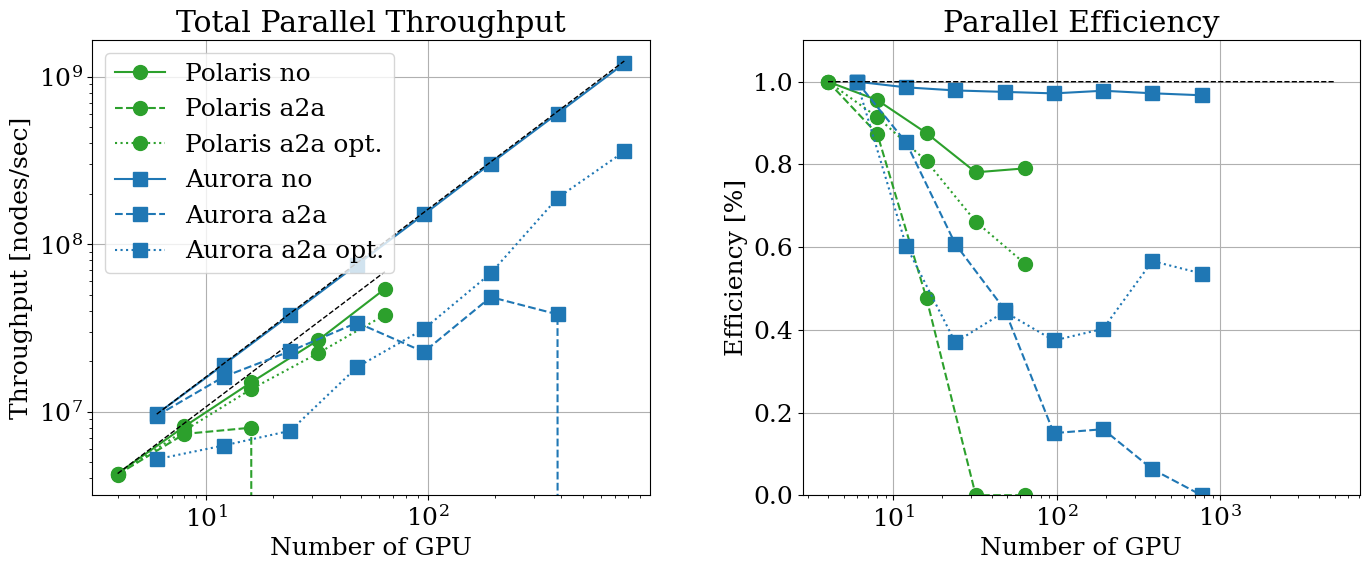

In [30]:
# Average parallel training throughput

polaris_gpu_list = [4, 8, 16, 32, 64]
polaris_no_single_node = polaris_no.train_fom['throughput_par'][2]
polaris_no_ideal = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_no_single_node for i in range(len(polaris_gpu_list))]
polaris_a2a_single_node = polaris_a2a.train_fom['throughput_par'][2]
polaris_a2a_ideal = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_a2a_single_node for i in range(len(polaris_gpu_list))]
polaris_a2ao_single_node = polaris_a2ao.train_fom['throughput_par'][2]
polaris_a2ao_ideal = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_a2ao_single_node for i in range(len(polaris_gpu_list))]

aurora_gpu_list = [6, 12, 24, 48, 96, 192, 384, 768]
aurora_no_single_node = aurora_no.train_fom['throughput_par'][3]
aurora_no_ideal = [aurora_gpu_list[i]/aurora_gpu_list[0]*aurora_no_single_node for i in range(len(aurora_gpu_list))]
aurora_a2a_single_node = aurora_a2a.train_fom['throughput_par'][3]
aurora_a2a_ideal = [aurora_gpu_list[i]/aurora_gpu_list[0]*aurora_a2a_single_node for i in range(len(aurora_gpu_list))]
aurora_a2ao_single_node = aurora_a2ao.train_fom['throughput_par'][3]
aurora_a2ao_ideal = [aurora_gpu_list[i]/aurora_gpu_list[0]*aurora_a2ao_single_node for i in range(len(aurora_gpu_list))]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axs[0].plot(polaris_gpu_list, polaris_no.train_fom['throughput_par'][2:],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[0].plot(polaris_gpu_list, polaris_a2a.train_fom['throughput_par'][2:],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
axs[0].plot(polaris_gpu_list, polaris_a2ao.train_fom['throughput_par'][2:],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')
axs[0].plot(polaris_gpu_list, polaris_no_ideal,c="k",ls="--",linewidth=1)

axs[0].plot(aurora_gpu_list, aurora_no.train_fom['throughput_par'][3:],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs[0].plot(aurora_gpu_list, aurora_a2a.train_fom['throughput_par'][3:],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs[0].plot(aurora_gpu_list, aurora_a2ao.train_fom['throughput_par'][3:],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')
axs[0].plot(aurora_gpu_list, aurora_no_ideal,c="k",ls="--",linewidth=1)


axs[1].plot(polaris_gpu_list, polaris_no.train_fom['throughput_par'][2:]/polaris_no_ideal,label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[1].plot(polaris_gpu_list, polaris_a2a.train_fom['throughput_par'][2:]/polaris_a2a_ideal,label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
axs[1].plot(polaris_gpu_list, polaris_a2ao.train_fom['throughput_par'][2:]/polaris_a2ao_ideal,label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs[1].plot(aurora_gpu_list, aurora_no.train_fom['throughput_par'][3:]/aurora_no_ideal,label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs[1].plot(aurora_gpu_list, aurora_a2a.train_fom['throughput_par'][3:]/aurora_a2a_ideal,label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs[1].plot(aurora_gpu_list, aurora_a2ao.train_fom['throughput_par'][3:]/aurora_a2ao_ideal,label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')
axs[1].plot([i for i in range(4,5000)], [1 for i in range(4,5000)],c="k",ls="--",linewidth=1)


for i in range(2):
    axs[i].set_xscale("log")
    axs[i].grid()
    axs[i].set_xlabel('Number of GPU')

axs[0].set_yscale("log")
axs[1].set_ylim(0,1.1)
#fig.legend(bbox_to_anchor=(1.25,0.7))
axs[0].legend(loc='upper left')
axs[0].set_ylabel('Throughput [nodes/sec]')
axs[0].set_title('Total Parallel Throughput')
axs[1].set_ylabel('Efficiency [%]')
axs[1].set_title('Parallel Efficiency')
fig.tight_layout(pad=3.0)

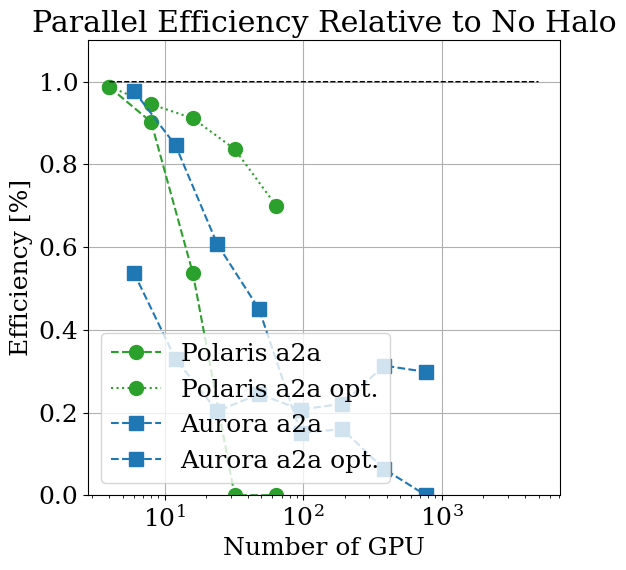

In [31]:
# Average parallel training throughput, relative to model run with no halo exchange

polaris_gpu_list = [4, 8, 16, 32, 64]
aurora_gpu_list = [6, 12, 24, 48, 96, 192, 384, 768]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
axs.plot(polaris_gpu_list, polaris_a2a.train_fom['throughput_par'][2:]/polaris_no.train_fom['throughput_par'][2:],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
axs.plot(polaris_gpu_list, polaris_a2ao.train_fom['throughput_par'][2:]/polaris_no.train_fom['throughput_par'][2:],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs.plot(aurora_gpu_list, aurora_a2a.train_fom['throughput_par'][3:]/aurora_no.train_fom['throughput_par'][3:],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs.plot(aurora_gpu_list, aurora_a2ao.train_fom['throughput_par'][3:]/aurora_no.train_fom['throughput_par'][3:],label = "Aurora a2a opt.",marker="s",ls="--",markersize=10,color='tab:blue')
axs.plot([i for i in range(4,5000)], [1 for i in range(4,5000)],c="k",ls="--",linewidth=1)

axs.set_xscale("log")
axs.grid()
axs.set_xlabel('Number of GPU')

#fig.legend(bbox_to_anchor=(1.25,0.7))
axs.set_ylim(0,1.1)
axs.legend(loc='lower left')
axs.set_ylabel('Efficiency [%]')
axs.set_title('Parallel Efficiency Relative to No Halo')
fig.tight_layout(pad=3.0)

Text(0.5, 1.0, 'Difference between Epoch and Batch Time')

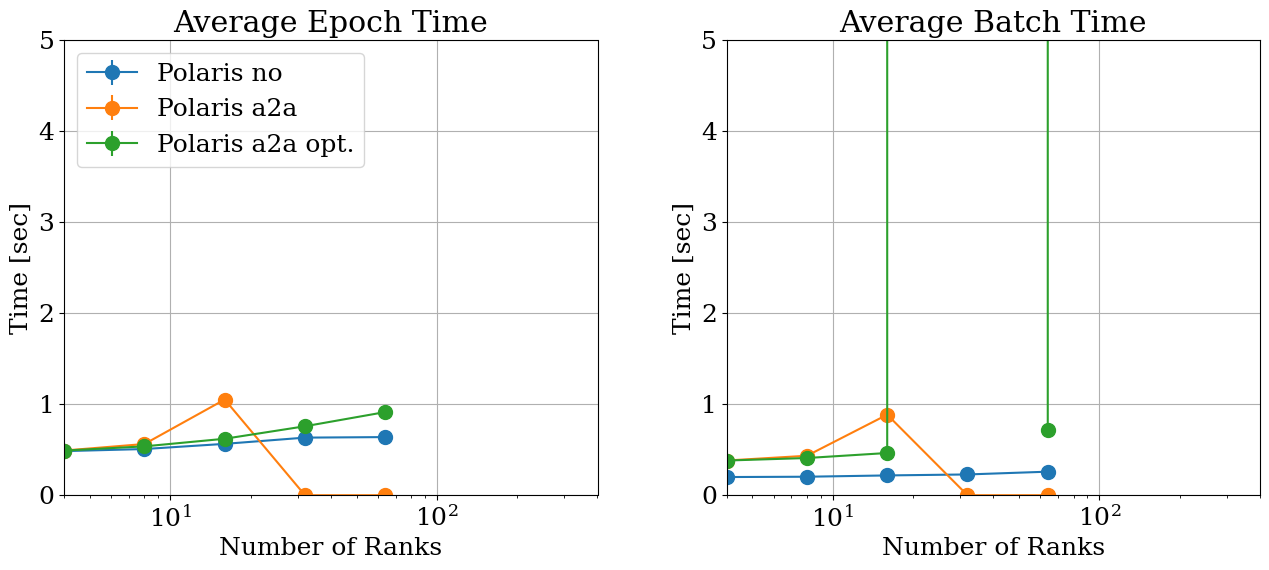

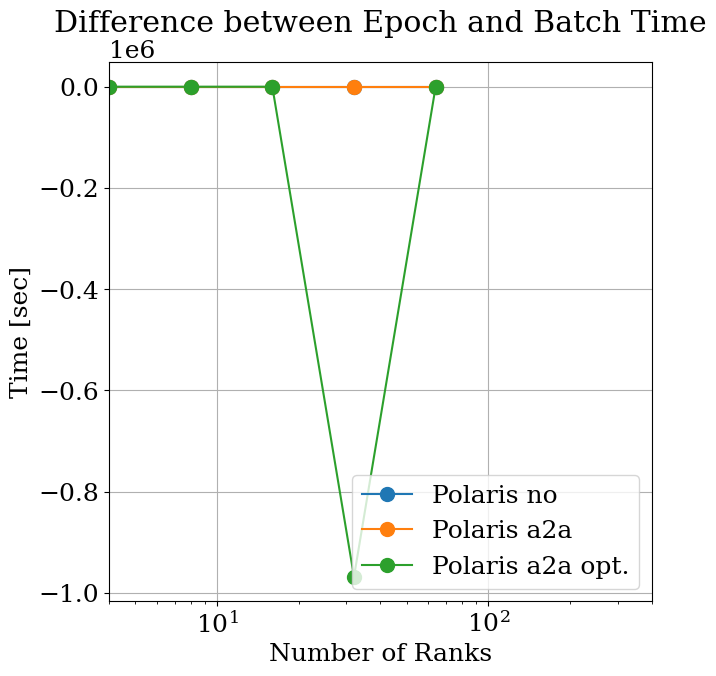

In [34]:
# Epoch and batch timings, and their difference

polaris_gpu_list = [4, 8, 16, 32, 64]
aurora_gpu_list = [6, 12, 24, 48, 96, 192, 384, 768, 1536, 3072]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axs[0].errorbar(polaris_gpu_list, polaris_no.train_fom['train_epoch'][2:,2],polaris_no.train_fom['train_epoch'][2:,3],label = "Polaris no",marker="o",ls="-",markersize=10)
axs[0].errorbar(polaris_gpu_list, polaris_a2a.train_fom['train_epoch'][2:,2],polaris_a2a.train_fom['train_epoch'][2:,3],label = "Polaris a2a",marker="o",ls="-",markersize=10)
axs[0].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['train_epoch'][2:,2],polaris_a2ao.train_fom['train_epoch'][2:,3],label = "Polaris a2a opt.",marker="o",ls="-",markersize=10)
#axs[0,0].errorbar(aurora_gpu_list, aurora.train_fom['forward_pass'][3:,2],aurora.train_fom['forward_pass'][3:,3],label = "Aurora",marker="s",ls="-",markersize=10)

axs[1].errorbar(polaris_gpu_list, polaris_no.train_fom['train_batch'][2:,2],polaris_no.train_fom['train_batch'][2:,3],label = "Polaris",marker="o",ls="-",markersize=10)
axs[1].errorbar(polaris_gpu_list, polaris_a2a.train_fom['train_batch'][2:,2],polaris_a2a.train_fom['train_batch'][2:,3],label = "Polaris a2a",marker="o",ls="-",markersize=10)
axs[1].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['train_batch'][2:,2],polaris_a2ao.train_fom['train_batch'][2:,3],label = "Polaris a2a opt.",marker="o",ls="-",markersize=10)
#axs[0,1].errorbar(aurora_gpu_list, aurora.train_fom['loss'][3:,2],aurora.train_fom['loss'][3:,3],label = "Aurora",marker="s",ls="-",markersize=10)

for j in range(2):
    axs[j].set_xscale("log")
    axs[j].grid()
    axs[j].set_xlabel('Number of Ranks')
    axs[j].set_ylabel('Time [sec]')
    axs[j].set_xlim(4,400)
    axs[j].set_ylim(0,5)
    
axs[0].legend(loc='upper left')
axs[0].set_title('Average Epoch Time')
axs[1].set_title('Average Batch Time')
fig.tight_layout(pad=3.0)

fig1, axs1 = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
axs1.plot(polaris_gpu_list, polaris_no.train_fom['train_epoch'][2:,2]-polaris_no.train_fom['train_batch'][2:,2],label = "Polaris no",marker="o",ls="-",markersize=10)
axs1.plot(polaris_gpu_list, polaris_a2a.train_fom['train_epoch'][2:,2]-polaris_a2a.train_fom['train_batch'][2:,2],label = "Polaris a2a",marker="o",ls="-",markersize=10)
axs1.plot(polaris_gpu_list, polaris_a2ao.train_fom['train_epoch'][2:,2]-polaris_a2ao.train_fom['train_batch'][2:,2],label = "Polaris a2a opt.",marker="o",ls="-",markersize=10)

axs1.set_xscale("log")
axs1.grid()
axs1.set_xlabel('Number of Ranks')
axs1.set_ylabel('Time [sec]')
axs1.set_xlim(4,400)
#axs1.set_ylim(0.01,0.025)
axs1.legend(loc='lower right')

axs1.set_title('Difference between Epoch and Batch Time')


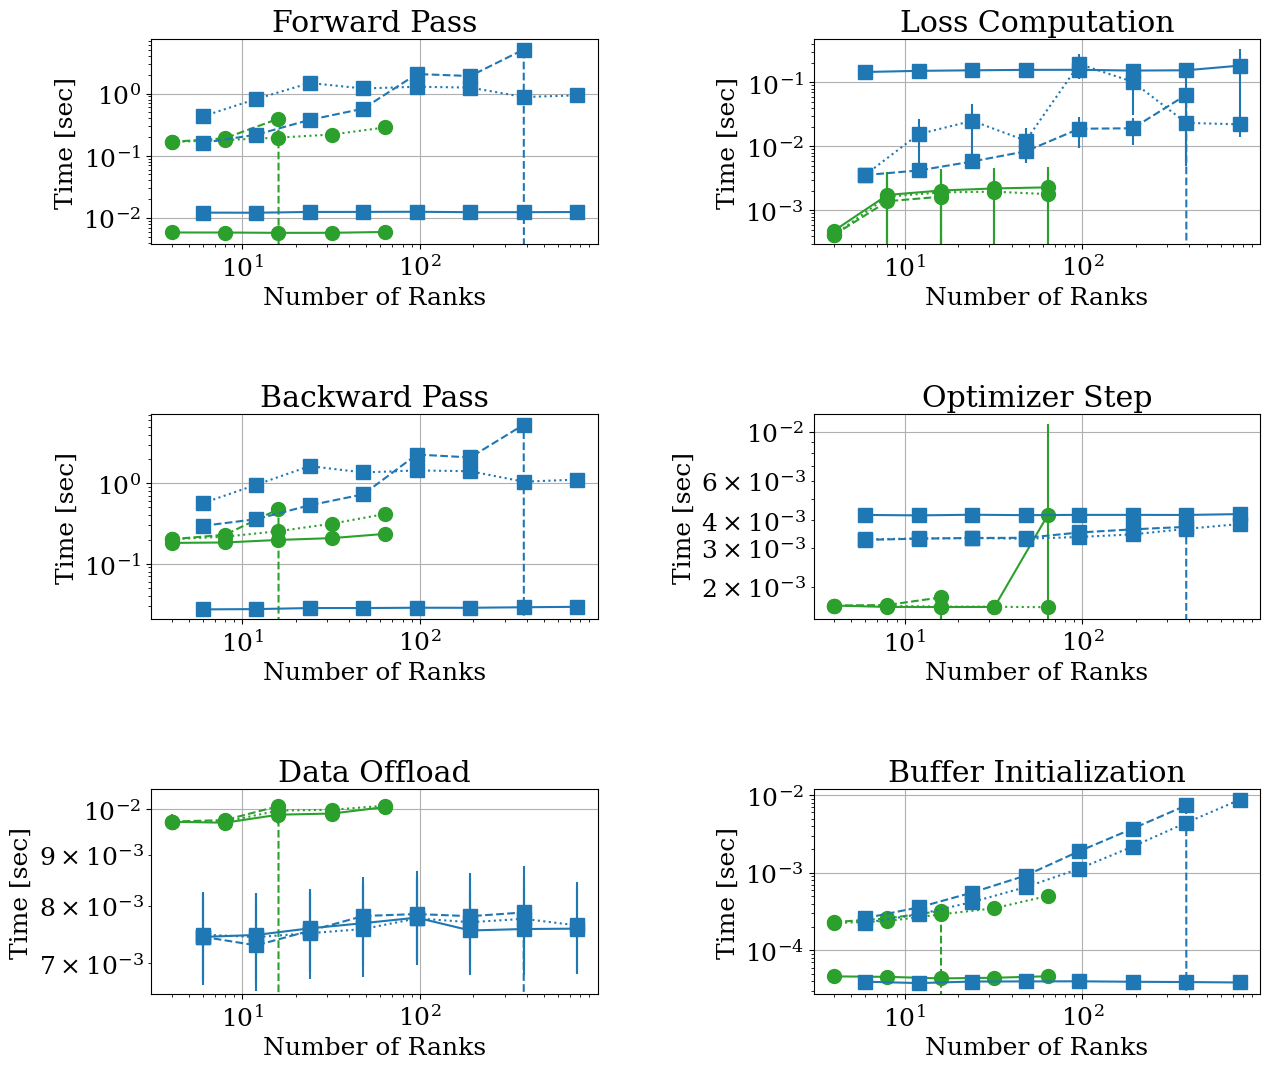

In [35]:
# Iteration timings

polaris_gpu_list = [4, 8, 16, 32, 64]
aurora_gpu_list = [6, 12, 24, 48, 96, 192, 384, 768]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
axs[0,0].errorbar(polaris_gpu_list, polaris_no.train_fom['forward_pass'][2:,2],polaris_no.train_fom['forward_pass'][2:,3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[0,0].errorbar(polaris_gpu_list, polaris_a2a.train_fom['forward_pass'][2:,2],polaris_a2a.train_fom['forward_pass'][2:,3],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
axs[0,0].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['forward_pass'][2:,2],polaris_a2ao.train_fom['forward_pass'][2:,3],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs[0,0].errorbar(aurora_gpu_list, aurora_no.train_fom['forward_pass'][3:,2],aurora_no.train_fom['forward_pass'][3:,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs[0,0].errorbar(aurora_gpu_list, aurora_a2a.train_fom['forward_pass'][3:,2],aurora_a2a.train_fom['forward_pass'][3:,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs[0,0].errorbar(aurora_gpu_list, aurora_a2ao.train_fom['forward_pass'][3:,2],aurora_a2ao.train_fom['forward_pass'][3:,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')


axs[0,1].errorbar(polaris_gpu_list, polaris_no.train_fom['loss'][2:,2],polaris_no.train_fom['loss'][2:,3],label = "Polaris",marker="o",ls="-",markersize=10,color='tab:green')
axs[0,1].errorbar(polaris_gpu_list, polaris_a2a.train_fom['loss'][2:,2],polaris_a2a.train_fom['loss'][2:,3],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
axs[0,1].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['loss'][2:,2],polaris_a2ao.train_fom['loss'][2:,3],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs[0,1].errorbar(aurora_gpu_list, aurora_no.train_fom['loss'][3:,2],aurora_no.train_fom['loss'][3:,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs[0,1].errorbar(aurora_gpu_list, aurora_a2a.train_fom['loss'][3:,2],aurora_a2a.train_fom['loss'][3:,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs[0,1].errorbar(aurora_gpu_list, aurora_a2ao.train_fom['loss'][3:,2],aurora_a2ao.train_fom['loss'][3:,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')


axs[1,0].errorbar(polaris_gpu_list, polaris_no.train_fom['backward_pass'][2:,2],polaris_no.train_fom['backward_pass'][2:,3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[1,0].errorbar(polaris_gpu_list, polaris_a2a.train_fom['backward_pass'][2:,2],polaris_a2a.train_fom['backward_pass'][2:,3],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
axs[1,0].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['backward_pass'][2:,2],polaris_a2ao.train_fom['backward_pass'][2:,3],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs[1,0].errorbar(aurora_gpu_list, aurora_no.train_fom['backward_pass'][3:,2],aurora_no.train_fom['backward_pass'][3:,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs[1,0].errorbar(aurora_gpu_list, aurora_a2a.train_fom['backward_pass'][3:,2],aurora_a2a.train_fom['backward_pass'][3:,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs[1,0].errorbar(aurora_gpu_list, aurora_a2ao.train_fom['backward_pass'][3:,2],aurora_a2ao.train_fom['backward_pass'][3:,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')


axs[1,1].errorbar(polaris_gpu_list, polaris_no.train_fom['optimizer_step'][2:,2],polaris_no.train_fom['optimizer_step'][2:,3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[1,1].errorbar(polaris_gpu_list, polaris_a2a.train_fom['optimizer_step'][2:,2],polaris_a2a.train_fom['optimizer_step'][2:,3],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
axs[1,1].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['optimizer_step'][2:,2],polaris_a2ao.train_fom['optimizer_step'][2:,3],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs[1,1].errorbar(aurora_gpu_list, aurora_no.train_fom['optimizer_step'][3:,2],aurora_no.train_fom['optimizer_step'][3:,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs[1,1].errorbar(aurora_gpu_list, aurora_a2a.train_fom['optimizer_step'][3:,2],aurora_a2a.train_fom['optimizer_step'][3:,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs[1,1].errorbar(aurora_gpu_list, aurora_a2ao.train_fom['optimizer_step'][3:,2],aurora_a2ao.train_fom['optimizer_step'][3:,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')


axs[2,0].errorbar(polaris_gpu_list, polaris_no.train_fom['data_offload'][2:,2],polaris_no.train_fom['data_offload'][2:,3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[2,0].errorbar(polaris_gpu_list, polaris_a2a.train_fom['data_offload'][2:,2],polaris_a2a.train_fom['data_offload'][2:,3],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
axs[2,0].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['data_offload'][2:,2],polaris_a2ao.train_fom['data_offload'][2:,3],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs[2,0].errorbar(aurora_gpu_list, aurora_no.train_fom['data_offload'][3:,2],aurora_no.train_fom['data_offload'][3:,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs[2,0].errorbar(aurora_gpu_list, aurora_a2a.train_fom['data_offload'][3:,2],aurora_a2a.train_fom['data_offload'][3:,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs[2,0].errorbar(aurora_gpu_list, aurora_a2ao.train_fom['data_offload'][3:,2],aurora_a2ao.train_fom['data_offload'][3:,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')


axs[2,1].errorbar(polaris_gpu_list, polaris_no.train_fom['buffer_init'][2:,2],polaris_no.train_fom['buffer_init'][2:,3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[2,1].errorbar(polaris_gpu_list, polaris_a2a.train_fom['buffer_init'][2:,2],polaris_a2a.train_fom['buffer_init'][2:,3],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
axs[2,1].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['buffer_init'][2:,2],polaris_a2ao.train_fom['buffer_init'][2:,3],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs[2,1].errorbar(aurora_gpu_list, aurora_no.train_fom['buffer_init'][3:,2],aurora_no.train_fom['buffer_init'][3:,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs[2,1].errorbar(aurora_gpu_list, aurora_a2a.train_fom['buffer_init'][3:,2],aurora_a2a.train_fom['buffer_init'][3:,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs[2,1].errorbar(aurora_gpu_list, aurora_a2ao.train_fom['buffer_init'][3:,2],aurora_a2ao.train_fom['buffer_init'][3:,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')


for i in range(3):
    for j in range(2):
        axs[i,j].set_xscale("log")
        axs[i,j].set_yscale("log")
        axs[i,j].grid()
        axs[i,j].set_xlabel('Number of Ranks')
        axs[i,j].set_ylabel('Time [sec]')

axs[0,0].set_title('Forward Pass')
axs[0,1].set_title('Loss Computation')
axs[1,0].set_title('Backward Pass')
axs[1,1].set_title('Optimizer Step')
axs[2,0].set_title('Data Offload')
axs[2,1].set_title('Buffer Initialization')
fig.tight_layout(pad=3.0)

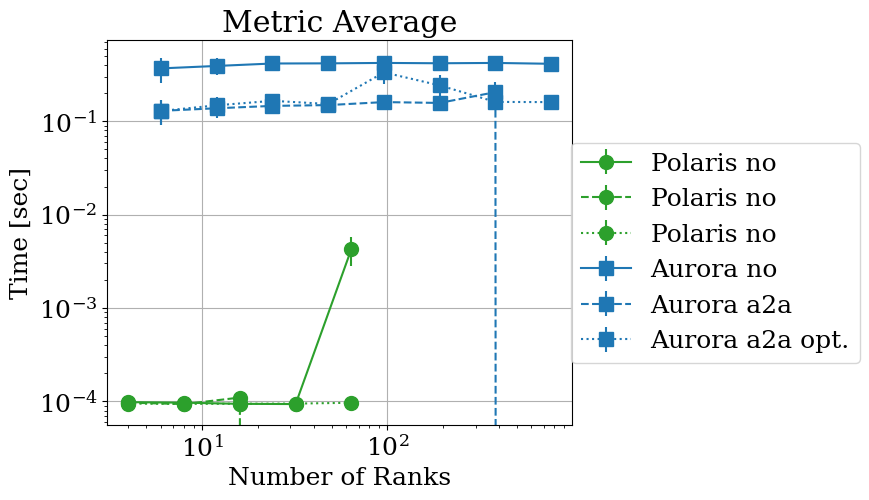

In [36]:
# Metric average for loss

polaris_gpu_list = [4, 8, 16, 32, 64]
aurora_gpu_list = [6, 12, 24, 48, 96, 192, 384, 768]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
axs.errorbar(polaris_gpu_list, polaris_no.train_fom['collectives'][2:,2],polaris_no.train_fom['collectives'][2:,3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs.errorbar(polaris_gpu_list, polaris_a2a.train_fom['collectives'][2:,2],polaris_a2a.train_fom['collectives'][2:,3],label = "Polaris no",marker="o",ls="--",markersize=10,color='tab:green')
axs.errorbar(polaris_gpu_list, polaris_a2ao.train_fom['collectives'][2:,2],polaris_a2ao.train_fom['collectives'][2:,3],label = "Polaris no",marker="o",ls=":",markersize=10,color='tab:green')

axs.errorbar(aurora_gpu_list, aurora_no.train_fom['collectives'][3:,2],aurora_no.train_fom['collectives'][3:,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs.errorbar(aurora_gpu_list, aurora_a2a.train_fom['collectives'][3:,2],aurora_a2a.train_fom['collectives'][3:,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs.errorbar(aurora_gpu_list, aurora_a2ao.train_fom['collectives'][3:,2],aurora_a2ao.train_fom['collectives'][3:,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')

axs.set_yscale("log")
axs.set_xscale("log")
axs.grid()
axs.set_xlabel('Number of Ranks')
axs.set_ylabel('Time [sec]')

axs.set_title('Metric Average')
fig.legend(bbox_to_anchor=(1.4,0.7))
#axs[0,1].set_title('Loss Computation')
#axs[1,0].set_title('Backward Pass')
#axs[1,1].set_title('Optimizer Step')
#fig.tight_layout(pad=3.0)

In [ ]:
polaris_gpu_list = [4, 8, 16, 32]

polaris_no_sum = polaris_no.train_fom['forward_pass'][2:,2] + \
                 polaris_no.train_fom['loss'][2:,2] + \
                 polaris_no.train_fom['backward_pass'][2:,2] + \
                 polaris_no.train_fom['optimizer_step'][2:,2] + \
                 polaris_no.train_fom['data_offload'][2:,2] + \
                 polaris_no.train_fom['buffer_init'][2:,2]
polaris_a2a_sum = polaris_a2a.train_fom['forward_pass'][2:,2] + \
                 polaris_a2a.train_fom['loss'][2:,2] + \
                 polaris_a2a.train_fom['backward_pass'][2:,2] + \
                 polaris_a2a.train_fom['optimizer_step'][2:,2] + \
                 polaris_a2a.train_fom['data_offload'][2:,2] + \
                 polaris_a2a.train_fom['buffer_init'][2:,2]
polaris_a2ao_sum = polaris_a2ao.train_fom['forward_pass'][2:,2] + \
                 polaris_a2ao.train_fom['loss'][2:,2] + \
                 polaris_a2ao.train_fom['backward_pass'][2:,2] + \
                 polaris_a2ao.train_fom['optimizer_step'][2:,2] + \
                 polaris_a2ao.train_fom['data_offload'][2:,2] + \
                 polaris_a2ao.train_fom['buffer_init'][2:,2]


fig1, axs1 = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
axs1.plot(polaris_gpu_list, polaris_no.train_fom['train_batch'][2:,2]-polaris_no_sum,label = "Polaris no",marker="o",ls="-",markersize=10)
axs1.plot(polaris_gpu_list, polaris_a2a.train_fom['train_batch'][2:,2]-polaris_a2a_sum,label = "Polaris a2a",marker="o",ls="-",markersize=10)
axs1.plot(polaris_gpu_list, polaris_a2ao.train_fom['train_batch'][2:,2]-polaris_a2ao_sum,label = "Polaris a2a opt.",marker="o",ls="-",markersize=10)

axs1.set_xscale("log")
axs1.grid()
axs1.set_xlabel('Number of Ranks')
axs1.set_ylabel('Time [sec]')
axs1.set_xlim(4,400)
#axs1.set_ylim(0.01,0.025)
axs1.legend(loc='lower right')

axs1.set_title('Difference between Epoch and Batch Time')

In [ ]:
print(polaris_no.train_fom['train_batch'][2:,2]/polaris_no.train_fom['train_batch'][2,2])
print(polaris_no_sum/polaris_no_sum[0])

In [ ]:
tmp = polaris_no.train_fom['forward_pass'][2:,2]+polaris_no.train_fom['backward_pass'][2:,2]
print(polaris_no_sum)
print(tmp)
print(tmp/polaris_no_sum)
print(polaris_no.train_fom['train_batch'][2:,2])
print(polaris_no.train_fom['train_batch'][2:,2]/polaris_no.train_fom['train_batch'][2,2])
print(polaris_no_sum/polaris_no_sum[0])

In [ ]:
tmp = polaris_a2ao.train_fom['forward_pass'][2:,2]+polaris_a2ao.train_fom['backward_pass'][2:,2]
print(polaris_a2ao_sum)
print(tmp)
print(tmp/polaris_a2ao_sum)
print(polaris_a2ao.train_fom['train_batch'][2:,2]/polaris_a2ao.train_fom['train_batch'][2,2])
print(polaris_a2ao_sum/polaris_a2ao_sum[0])